<a href="https://colab.research.google.com/github/jarrydmartinx/ml-basics/blob/master/sampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sampling

In [0]:
! pip install -q plotnine

In [0]:
import numpy as np
import pandas as pd
import plotnine as gg
import pdb
from scipy import stats

from typing import Callable, Tuple, List

## Ancestral Sampling from a Graphical Model
@TODO: Revise Ancestral Sampling

## Sampling from Invertible Closed Form Distributions: Inverse CDF transform


* Let $F$ be a continuous cumulative distribution function, and assume its inverse function $F^{-1}$ exists (using the infimum because CDFs are weakly monotonic and right-continuous):
$$ F^{-1}(u) = \inf \{ x \mid F(x) \geq u\}$$
* Suppose $Z~U(0, 1)$ is uniformly distributed in the unit interval.
* Claim: $F^{-1}(Z)$ has $F$ as its CDF. Proof:
\begin{align}
&\quad \mathbb{P}(F^{-1}(U) \leq x) \\
&= \mathbb{P}(U \leq F(x))\\
&= F(x) \qquad \text{because }  \mathbb{P}(U \leq y) = y \text{  when $U$ is uniform on $(0, 1)$}
\end{align}

In [0]:
def sample(inverse_cdf: Callable, size: int, params: List):
  """Takes an inverse cdf and paramters and generates size samples
  """
  u = np.random.rand(size)
  return inverse_cdf(u, params)

In [0]:
#@title Continuous Random Variables

def expon_inv_cdf(z: float, params: List[float]) -> float:
  if params is not None:
    lamb = params
  else:
    lamb = 1.
  
  return -(1 / lamb) * np.log(z / lamb)

samples = sample(expon_inv_cdf,params=(1),  size=(1000),)
print(samples[:5])
np.mean(samples), np.var(samples)

[0.04058843 0.47757381 1.60602579 1.58261271 3.99624607]


(0.9669871687957959, 0.8888593414110949)

In [0]:
from typing import Tuple

In [0]:
#@title Check it with scipy

from scipy import stats

def sample_expon(lamb: int = 1, size: Tuple = (1)):
  u = np.random.rand(size)
  return stats.expon.ppf(u, scale=1/lamb)

samples = sample_expon(size=(int(1000)))
np.mean(samples), np.var(samples)

(1.0424511640805938, 1.0602277433071234)

In [0]:
#@title Discrete Random Variables

def categorical_pmf(num_categories: int):
  vals = np.random.rand(num_categories)
  return vals / np.sum(vals)

def categorical_inv_cdf(z: np.ndarray, params: List):
 
  if len(params) == 1:
    num_categories = params[0]
    probs = categorical_pmf(num_categories)  # [C]
  else:
    probs = params
    
  if z.ndim != 1:
    raise ValueError('z must be flat.')
  num_samples = z.shape[0]  # "B"
  
  cdf = np.cumsum(probs)  # [C]
  cdf = np.expand_dims(cdf, axis=0)  # [1, C]
  z = np.expand_dims(z, axis=-1)  # [B, 1]
  bools = cdf > z  # [B, C]
  print(bools)
  
  return np.argmax(bools, axis=1)  # [B]



samples = sample(categorical_inv_cdf, params=[4], size=10)
print(samples)
mode = np.bincount(samples).argmax()
print(mode)

[[False False False  True]
 [False False False  True]
 [ True  True  True  True]
 [False False  True  True]
 [ True  True  True  True]
 [False  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [False  True  True  True]
 [False False  True  True]]
[3 3 0 2 0 1 0 0 1 2]
0


## Box Mueller

### Sampling from a $\mathcal{N}(0, 1)$ Gaussian
* Generate pairs of uniformly distrubted $z_1, z_2 \in (-1, 1)$, which we can do by transforming a variable distributed uniformly over $(0, 1)$ using $z = 2z -1$
* We keep the pair if it lies within the the unit circle: i.e. if $z_1^2 + z_2^2 \leq 1$
* We are left with pairs $z_1, z_2$ uniformly distributed within the unit circle. The probability of each pair is 1/(area of unit circle) =  $1/\pi$
* We calculate the magnitude of the resultant vector $r = |(z_1, z_2)| = z_1^2 + z_2^2$ 
* We compute the following transformation for each element of the pair:
$$ y_i = z_i\bigg(\frac{-2 \ln r^2}{r^2}\bigg)^{1/2} $$
* Each $y_i$ will be $\sim \mathcal{N}(0, 1)$

In [0]:
def sample_normal():
  pass

#TODO(jarryd@google.com): Implement the Box Mueller algorithm described above

#TODO(jarryd@google.com): Work out why this is an example of the inverse CDF trick
# or why it's a related transform method. Surely the expression for y_i is basically 
# the inverse pdf 

### Sampling from a Gaussian with arbitrary mean and variance

In [0]:
def reparametrise(mean: float, variance: float) -> float:
  pass

#TODO(jarryd@google.com): This function should take a normally distributed sample
# and output a sample from a Gaussian with the given mean and variance

## Rejection Sampling

### Constraints and Assumptions
* Suppose we wish to sample from a distribution $p(z)$ that doesn't have a closed form inverse cdf.
* Assume that sampling from $p(z)$ directly is difficult
* Assume we can easily evaluate $p(z)$, for any $z$, up to some normalising constant $Z_p$:
$$ p(z) = \frac{1}{Z_p} \tilde{p}(z)$$
That is, we can easily evaluate $\tilde{p}(z)$
* Assume we have a *proposal distribution* $q(z)$ that we can easily sample from.
* We introduce a constant $k$ such that $kq(z) \geq \tilde{p}(z)$ for all values of $z$

### Sampling Procedure
* Sample a number $z_0$ from the proposal distribution $q(z)$
* We generate a number $u_0$ from the uniform distribution over $[0, kq(z_0)]$
* If $u_0 \leq \tilde{p}(z_0)$, accept the sample, otherwise reject.
  * The rejected $(z_0, u_0)$ pairs are uniformly distributed in the region between $\tilde{p}(z_0)$ and $q(z)$
  * The accepted $(z_0, u_0)$ pairs are uniformly distributed in the region under $\tilde{p}(z_0)$
  * Hence, the accepted $z_0$ are distributed according to 

In [0]:
def rejection_sample(desired_pdf=stats.beta.pdf, k=6, size=100000):
  # Uses a Gaussian distribution as the proposal distribution q

  x = np.random.normal(size=size) #[size] 
  p = stats.beta.pdf(x, 3, 4) #[size] 
  scaled_q = k * stats.norm.pdf(x) #[size] 
  z = np.random.uniform(size=size) #[size] uniform samples in (0,1)
  accept = (z * scaled_q) < p #[size], a boolean mask
  samples = x[accept]

  accept_rate = len(samples) / size
  print('Accept rate: {}'.format(accept_rate))
  return samples

In [0]:
xs = np.linspace(-3, 3, 500)
qs = stats.norm.pdf(xs)
ps = stats.beta.pdf(xs, 3, 4)


p_df = pd.DataFrame({'x': xs, 'value': ps, 'distribution': 'p'})
q_df = pd.DataFrame({'x': xs, 'value': 6 * qs, 'distribution': 'q'})
df = pd.concat([p_df, q_df])

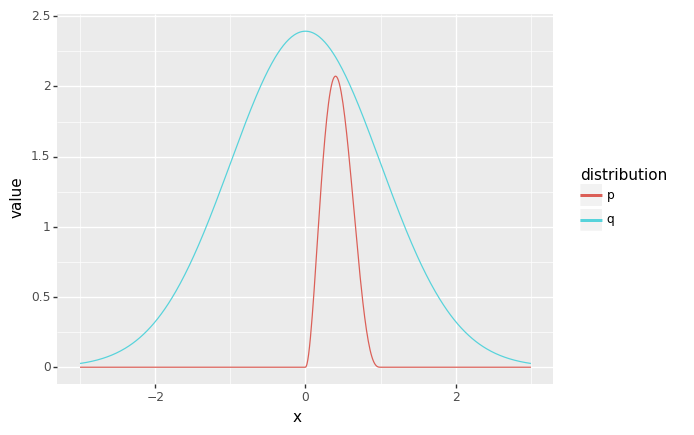

<ggplot: (-9223363256962948306)>

In [0]:
p = (gg.ggplot(df)
     + gg.aes(x='x', y='value', color='distribution')
     + gg.geom_line()
     + gg.xlim(-3, 3)
    )
p

## Importance Sampling And Expectations

### Notes on Sampling to estimate expectations of functions of RVs


* Most of the time, we want to evaluate distributions for the purposes of evaluating expectations
* The fundamental problem sampling methods address is that of approximating the expectation below wrt the distribution $ p(\mathbf{z})$
\begin{align}
\mathbb{E}[f(\mathbf{z})]  &=\int f(\mathbf{z})p(\mathbf{z}) d\mathbf{z}
\end{align}

* We obtain a set of samples $\{\mathbf{z}^{(l)}\}$, $l \in \{1\ldots L\}$
* The expectation may approximated by a finite sum:
\begin{align}
\mathbb{E}[f(\mathbf{z})]  &\approx \hat{f} = \frac{1}{L}\sum_{l = 1}^L f(\mathbf{z}^{(l)})
\end{align}
* **Remember to divide by the number of samples!!!**
* The variance of the estimator  is
$$ var[\hat{f}] = \frac{1}{L}\mathbb{E}\big[(f - \mathbb{E}[f]) ^2\big]$$
which is the variance of the function f(z) under the distribution p(z). Hence the accuracy of the estimator does not depend on the dimensionality of $z$! So high accuracy may be achievable with a relatively small number of independent samples of z. However, the samples might not be independent, so the effective sample size might be much smaller.



### Importance Sampling Derivation

Suppose we need to evaluate an expectation wrt a distribution but we dont need to sample from that distribution directly
* Assume it's hard to sample from p(z) directly but that we can easily evaluate it for any z.
* We could just evaluate p(z) over a uniform grid, and approximate the expectation that way, but the number of terms grows exponentially with the dimensionality of $z$
* Also, if f(z) is small in regions where p(z) is large, and vice versa, then the expectation may be dominated by regions of small probability, implying that relatively large sample sizes will be required to achieve sufficient accuracy.
* We'd really like to choose to sample from regions where the product p(z)f(z) is large, as these contribute most to the sum.
* As with rejection sampling, we're going to draw samples from a *proposal distribution* q(z), and the efficiency of the procedure is going to depend on how well our proposal distribution fits our desired distribution. Makes sense. 
* The difference is we never have to be able to draw samples from the desired distribution.
* As before, we can even do it if we can only evaluate the desired distribution up to some normalisation, but let's not worry about that for now.



\begin{align}
\mathbb{E}[f] 
&= \int f(z) p(z) dz \\
&= \int f(z) \frac{p(z)}{q(z)} q(z) dz \\
&\simeq \frac{1}{L} \sum_{l=1}^{L} \frac{p(z^{(l)})}{q(z^{(l)})}f(z^{(l)}) \qquad {z^{(l)}} \sim q(z)
\end{align}
* The quantities $r_l = \frac{p(z^{(l)})}{q(z^{(l)})}f(z^{(l)})$ are called the importance weights.
* These correct for the bias introduced by sampling from the wrong distribution.
* Note from the form of the expression that q(z) should not be small or zero in regions where p(z) is large.
* If, as is often the case, p(z)f (z) is strongly varying and has a sig-
nificant proportion of its mass concentrated over relatively small regions of z space,
then the set of importance weights {r l } may be dominated by a few weights hav-
ing large values, with the remaining weights being relatively insignificant. Thus the
effective sample size can be much smaller than the apparent sample size L.
* A major drawback of importance sampling as a method is its potential to produce results that are arbitrarily bad with no diagnostic indication (unlike rejection sampling, which gives you a clear indication of its inefficiency).

### Importance Sampling Code

In [0]:
def imp_sampled_expect(num_samples: int,
                       f: Callable[[np.ndarray], np.ndarray] = lambda z: z,
                       p: Callable[[np.ndarray], np.ndarray] = stats.beta.pdf,
                       p_params: Tuple[float] = (3., 4.),
                       gauss_params: Tuple[float] = (.3, .3)) -> float:
  
  """ Computes expectation of f wrt the distribution p by importance sampling
  
  Assumes a Gaussian proposal distribution.
  """
  
  # Draw num_samples samples z from each proposal distribution q(z)
  z = np.random.normal(*gauss_params, size=num_samples) #[n]
  
  # Evaluate q(z) for all samples z
  q_z = stats.norm.pdf(z, *gauss_params) #[n]     
  
  # Evaluate p(z) for all samples z 
  p_z = p(z, *p_params) #[n]               
                        
  # Compute the importance weights r(z) for each sample z                      
  r_z = p_z / q_z #[n] 
  
  return (1 / num_samples) * np.sum(r_z * f(z)) # []

num_samples = 100000
expect_good = imp_sampled_expect(num_samples, gauss_params=(.4, .19))
expect_bad = imp_sampled_expect(num_samples, gauss_params=(0, 1))

err_good_fit = stats.beta.mean(*beta_params) - expect_good
err_bad_fit = stats.beta.mean(*beta_params) - expect_bad

print('Good Proposal Distribution: E[f]: {}, error: {}'.format(expect_good, 
                                                               err_good_fit))
print('Bad Proposal Distribution: E[f]: {}, error: {}'.format(expect_bad, 
                                                               err_bad_fit))

Good Proposal Distribution: E[f]: 0.4299035397584606, error: -0.0013321111870320257
Bad Proposal Distribution: E[f]: 0.4274718120359146, error: 0.0010996165355139365


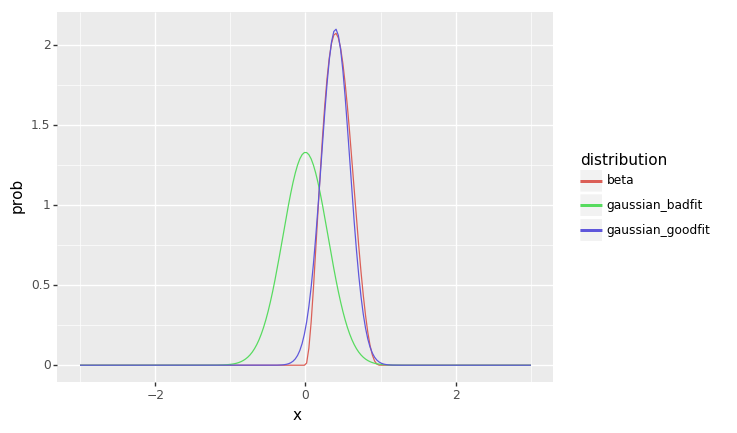

<ggplot: (8779888227462)>

In [0]:
xs = np.linspace(-3, 3, num=200)
betas = stats.beta.pdf(xs, 3, 4)
normals_good = stats.norm.pdf(xs, loc=.4, scale=.19)
normals_bad = stats.norm.pdf(xs, loc=0, scale=.3)

beta_df = pd.DataFrame({'x': xs, 'prob': betas, 'distribution': 'beta'})
normal_good_df = pd.DataFrame({'x': xs, 
                        'prob': normals_good, 
                        'distribution': 'gaussian_goodfit'})
normal_bad_df = pd.DataFrame({'x': xs,
                            'prob': normals_bad,
                            'distribution': 'gaussian_badfit'})

df = pd.concat([beta_df, normal_good_df, normal_bad_df])
plot = (gg.ggplot(df)
        + gg.aes(x='x', y='prob', color='distribution')
        + gg.geom_line()
        + gg.xlim(-3, 3)
       )

plot

## Markov Chain Monte Carlo

### Why MCMC?
* Because Importance Sampling and Rejection Sampling **suck** in high dimensional spaces.
* Too many rejections, importance weights are too small. Boy do I get that.
* In MCMC we again have a desired distribution that we can evaluate, perhaps up to some normalisation.
* We again sample from a proposal distribution that we can sample from directly, but **don't do so i.i.d**. Instead we maintain a record of the **current state** $z^{(\tau)}$, and the proposal distribution $q(z\mid z^{(\tau)})$ depends on the current state, and so the sequence of samples $z^{(1)}$, $z^{(2)}$... forms a Markov chain.

### Markov Chain Recap:
* A Markov chain is a sequence of random variables
* A first-order MC is one where a one-step conditional independence property holds: the Markov property
  * When represented as a graph this looks like a chain, so yeah.
* A MC is called (time-)homogeneous if the transition probabilities are the same for all $n$

### Invariance of distributions wrt MCs, Detailed Balance
* A distribution is said to be invariant, or stationary with respect to a MC if each step in the chain leaves that distribution invariant. For a homogeneous MC with transition probabilities $T(z', z)$ the distribution $p^*(z)$ is invariant if:
$$ p^*(z) = \sum_{z'} T (z, z') p^*(z') $$
* A MC can have many invariant distributions. (e.g. if $T$ is the identity then any distribution witll be an invariant distrubtion wrt to the MC defined by $T$).
* **Detailed balance** is a sufficient (but not necessary) condition for invariance:
$$ p^*(z) T (z, z') = p^*(z') T (z', z) $$
an MC satisfying detailed balance is also called **reversible**

### Using Markov Chains to sample from a distribution $p^*(z)$
Our goal is to use Markov chains to sample from a given distribution. We'll require that:
  1. Desired distribution == stationary distribution: i.e. the desired distribution $p^*(z)$ is invariant wrt the MC
  2. Ergodicity: The Markov chain $p(z^{(m)})$ must converge to the required invariant distribution $p*(z)$, *irrespective of the choice of initial distribution* $p(z^{(0)}).
    * The invariant distribution is then called the equilibrium distribution.
    * Clearly an ergodic Markov chain can only have one equilibrium distribution.
  


## The Metropolis algorithm
* We assume that the proposal distribution is symmetric, such that $q(z \mid z') = q(z' \mid z)$ for all $z', z$.
* Like in rejection sampling, a candidate sample is **accepted** with probability:
$$ A(z^*, z^{(\tau)}) = \min\bigg(1,\ \frac{p(z^*)}{p(z^{(\tau)})}\bigg)$$
by choosing a random number $u\sim U(0,1)$ and accepting if $A(z^*, z^{(\tau)}) > u$.
  *  **Note that if the step from $z^{(\tau)}$ to $z^*$ increases the value of p(z), then the candidate sample is certain to be kept**
  * Basically, you walk around by sampling your next step from the proposal distribution $q(z\mid z^{(\tau)})$,  and if you sample a point having higher probability according to your **desired distribution** $p(z)$, you accept that step, and keep going. Sometimes, even when the probability has dropped a bit, you still accept the step, with some probability. You're just trying to not drop too far on the p(z) landscape. The method is working well if you're doing better than random walking.
* If you reject the candidate sample, you '**reaccept**' the prior sample as the 'next' sample, and keep going. This leads to multiple copies of samples. 
  * It's like taking a step on a landscape with a blindfold on, if you step down too far, it makes sense to step back to where you were a moment ago, and then keep going. You pretend that you just turned on the spot for one timestep and ended up exactly where you were.
* As long as $p(z\mid z')$ is positive for all z, z' (sufficient but not necessary), **the distribution of $z^(\tau)$ tends to $p(z)$ as $\tau \to \infty$**.
  * Note however that the sequence $z^{(1)}, z^{(2)}\ldots$ is not a sequence of independent samples from $p(z)$, because successive samples are **highly correlated**.
  * Instead, we discard the sequence and start again for each new sample, only retaining say the $m^{\text{th}}$ (the last) sample from each sequence. For sufficiently large $m$, the retained samples $z^{m}$ will practically be independent, because of ergodicity.

## The Metropolis-Hastings Algorithm

* A generalisation of the basic Metropolis algorithm to the case where the proposal distribution is no longer a symmetric function of its arguments.
* At step $\tau$ we draw a sample $z^*$ from the proposal distribution $q_k(z\mid z^{(\tau)}$ and then accept it with probability:
$$ A_k(z^*, z^{(\tau)}) = \min \bigg(1,\ \frac{p(z^*)q_k(z^{(\tau)} \mid z^*)}{p(z)q_k(z^* \mid z^{(\tau)})}\bigg)$$
for a symmetric distribution the MH criterion reduces to the standard M criterion.
  * Here $k$ labels each of the set of possible transitions being considered.
  * Don't really get this but roughly it's just adjusting for the non-symmetry. Does backtracking nature of the alg have something to do with this?
  
@TODO(jarryd): Go through proof that p(z) is an invariant distribution of the Markov chain defined by the Metropolis-Hastings algorithm by showing that detailed balance is satisfied.

## Gibbs Sampling
A special case of the Metropolis Hastings algorithm. We first choose a distribution $p(z)$ which we wish to sample from. Then we choose an initial state, and then progressively sample new values for the individual elements of $\mathbf{z}$
  1. Choose an initial state $z$ for the Markov chain. i.e. Initialise $z_i: i = 1, ... , M$
  2. For $\tau = 1, ..., T$
    * Sample $z_1^{(\tau + 1)} \sim p(z_1 \mid z_2^{(\tau)}, \ldots \ z_M^{(\tau)}$)
    * Sample $z_2^{(\tau + 1)} \sim p(z_2 \mid z_1^{(\tau + 1)},\ z_3^{(\tau)} \ldots \ z_M^{(\tau)}$)
    
      $\vdots$
    * Sample $z_M^{(\tau + 1)} \sim p(z_1 \mid z_1^{(\tau + 1)},\ z_2^{(\tau+1)} \ldots \ z_{M-1}^{(\tau + 1)}$)

The joint distribution p(z) is invariant with respect to this markov chain because:
1. The marginal $p(z_i \mid z_{!i})$ is clearly invariant because the value of $z_{!i}$ is clearly unchanged. 
2. Each step also samples by definition from the correct conditional distribution $p(z_i\mid z_{!i})$
Because these conditional and marginal distributions together specify the joint distribution, we see that the joint is itself invariant wrt this markov chain

TODO(jarryd): show that the acceptance probability, if we interpret this as a special case of the MH algorithm, is always 1 (samples are always accepted).


## Playground


In [0]:
#     categorical_samples = - np.ones(num_samples, dtype=np.int32)
#   for idx in range(num_samples):
#     for i in range(len(probs)):
#       if z[idx] <= cdf[i]:
#         categorical_samples[idx] = i
#         break
#   return categorical_samples

In [0]:
# # Parameters for Gaussian proposal distribution q(z)
# gauss_params_good = .4, .19
# gauss_params_bad = 0, 1

# # Parameters for desired Beta distribution p(z)
# beta_params = 3, 4

# # Draw size samples z from each proposal distribution q(z)
# z_good = np.random.normal(size=100, *gauss_params_good) #[size]
# z_bad = np.random.normal(size=100, *gauss_params_bad) #[size]

# # Evaluate q(z) for all samples z drawn from q
# q_z_good = stats.norm.pdf(z_good, *gauss_params_good)
# q_z_bad = stats.norm.pdf(z_bad, *gauss_params_bad)

# # Evaluate p(z) for all samples z drawn from q
# p_z_good = stats.beta.pdf(z_good, 3, 4) #[size]
# p_z_bad = stats.beta.pdf(z_bad, 3, 4) #[size]